In [28]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [29]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize, sent_tokenize, wordpunct_tokenize, TreebankWordTokenizer, TweetTokenizer

In [30]:
import csv,sys
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest,chi2 
from sklearn.metrics import classification_report

### Import Dataset

In [31]:
df = pd.read_table("project2_training_data.txt", names = ['doc'], header = None)

In [5]:
df.head(5)

,doc
0,Merrill Lynch analyst Campbell Morgan upgraded...
1,Eriikka S+Âderstr+Âm has previously held sever...
2,The webcast may be followed online on the comp...
3,"Typical end-uses include roof structures , flo..."
4,The sale will be finalized in September or Oct...


##### Train data label

In [32]:
df1=pd.read_table('project2_training_data_labels.txt', names =['class'],header = None  )

In [7]:
df1

,class
0,positive
1,neutral
2,neutral
3,neutral
4,neutral
...,...
1806,positive
1807,neutral
1808,neutral
1809,neutral


In [33]:
df['class'] = df1

In [9]:
df.head(10)

,doc,class
0,Merrill Lynch analyst Campbell Morgan upgraded...,positive
1,Eriikka S+Âderstr+Âm has previously held sever...,neutral
2,The webcast may be followed online on the comp...,neutral
3,"Typical end-uses include roof structures , flo...",neutral
4,The sale will be finalized in September or Oct...,neutral
5,Finnish steel maker Rautaruukki Oyj ( Ruukki )...,positive
6,The works will include the laying of natural s...,neutral
7,The order was valued at over EUR15m .,neutral
8,Finnish metal products company Componenta Oyj ...,positive
9,Coffee will be served starting at 14:30 EET as...,neutral


#### Data loading for existing models (only used for feature selection and existing model training)
##### Converted the dataset into the list of strings

In [8]:
# Load data
f1=open('project2_training_data.txt', 'r', encoding="utf8") 
data1 = list(csv.reader(f1,delimiter='\t'))
data = []
for i in data1:
    for j in i:
        data.append(j)

In [9]:
# Load labels
f2=open('project2_training_data_labels.txt', 'r', encoding="utf8") 
labels1 = list(csv.reader(f2,delimiter='\t'))
labels = []
for i in labels1:
    for j in i:
        labels.append(j)

### Text-Preprocessing

#### Stopword removal

In [34]:
import re
from nltk.corpus import stopwords  ## stopwords from nltk corpus
import nltk

b = list(df["doc"])
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    review = re.sub(r'[^\w\s]', '', review)
    review = re.sub('()', '', review)
    review = re.sub(r'[0-9]+', '', review)

    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
  
    review = ' '.join(review)

    corpus.append(review)
df = df.assign(clean_doc = corpus)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ABC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ABC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
df['doc_clean'] = df['clean_doc'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [36]:
df_clean = df[['doc_clean','class']]

In [15]:
df_clean

,doc_clean,class
0,merrill lynch analyst campbell morgan upgraded...,positive
1,eriikka sâderstrâm previously held several pos...,neutral
2,webcast may followed online company website ww...,neutral
3,typical enduses include roof structures floori...,neutral
4,sale finalized september october company said,neutral
...,...,...
1806,appointment kaupthing bank aims coordinate cap...,positive
1807,jon risfelt previously held operational execut...,neutral
1808,group intends relocate warehouse office space ...,neutral
1809,contract includes software licences applicatio...,neutral


#### Stemming and Lemmatization

In [37]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


df_clean['text_lemmatized'] = df_clean.doc_clean.apply(lemmatize_text)

In [38]:
from nltk.stem.snowball import SnowballStemmer
# Use English stemmer.
stemmer = SnowballStemmer("english")
df_clean['stemmed'] = df_clean['text_lemmatized'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

In [39]:
for i in range(len(df_clean['text_lemmatized'])):
    df_clean['text_lemmatized'][i] = ' '.join(df_clean['text_lemmatized'][i])

In [40]:
df_clean

,doc_clean,class,text_lemmatized,stemmed
0,merrill lynch analyst campbell morgan upgraded...,positive,merrill lynch analyst campbell morgan upgraded...,"[merril, lynch, analyst, campbel, morgan, upgr..."
1,eriikka sâderstrâm previously held several pos...,neutral,eriikka sâderstrâm previously held several pos...,"[eriikka, sâderstrâm, previous, held, sever, p..."
2,webcast may followed online company website ww...,neutral,webcast may followed online company website ww...,"[webcast, may, follow, onlin, compani, websit,..."
3,typical enduses include roof structures floori...,neutral,typical enduses include roof structure floorin...,"[typic, endus, includ, roof, structur, floor, ..."
4,sale finalized september october company said,neutral,sale finalized september october company said,"[sale, final, septemb, octob, compani, said]"
...,...,...,...,...
1806,appointment kaupthing bank aims coordinate cap...,positive,appointment kaupthing bank aim coordinate capi...,"[appoint, kaupth, bank, aim, coordin, capit, m..."
1807,jon risfelt previously held operational execut...,neutral,jon risfelt previously held operational execut...,"[jon, risfelt, previous, held, oper, execut, p..."
1808,group intends relocate warehouse office space ...,neutral,group intends relocate warehouse office space ...,"[group, intend, reloc, warehous, offic, space,..."
1809,contract includes software licences applicatio...,neutral,contract includes software licence application...,"[contract, includ, softwar, licenc, applic, ma..."


In [41]:
df_clean_1 = df_clean[['doc_clean','class']]

In [27]:
#df_clean_1 = df_clean_1.rename(columns={'text_lemmatized':'doc_clean'})

In [42]:
df_clean_1

,doc_clean,class
0,merrill lynch analyst campbell morgan upgraded...,positive
1,eriikka sâderstrâm previously held several pos...,neutral
2,webcast may followed online company website ww...,neutral
3,typical enduses include roof structures floori...,neutral
4,sale finalized september october company said,neutral
...,...,...
1806,appointment kaupthing bank aims coordinate cap...,positive
1807,jon risfelt previously held operational execut...,neutral
1808,group intends relocate warehouse office space ...,neutral
1809,contract includes software licences applicatio...,neutral


In [43]:
df_clean_2 = df_clean[['text_lemmatized','class']]

In [44]:
df_clean_2 = df_clean_2.rename(columns={'text_lemmatized':'all_cleaned'})

In [45]:
df_clean_2

,all_cleaned,class
0,merrill lynch analyst campbell morgan upgraded...,positive
1,eriikka sâderstrâm previously held several pos...,neutral
2,webcast may followed online company website ww...,neutral
3,typical enduses include roof structure floorin...,neutral
4,sale finalized september october company said,neutral
...,...,...
1806,appointment kaupthing bank aim coordinate capi...,positive
1807,jon risfelt previously held operational execut...,neutral
1808,group intends relocate warehouse office space ...,neutral
1809,contract includes software licence application...,neutral


## Data analyis and Visualization

#### Bar-Plot for each class

In [49]:
pos = 0
neut = 0
neg = 0
for i in df_clean['class']:
    if i == 'positive':
        pos += 1
    elif i == 'negative':
        neg += 1
    else:
        neut += 1

In [50]:
values = ['positive', 'neutral', 'negative']
frequencies = [pos, neut, neg]

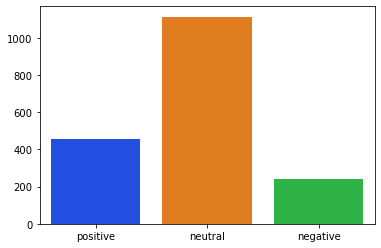

In [51]:
axes = sns.barplot(x=values, y=frequencies, palette='bright')

#### Doc-length vs class plot

In [46]:
doc_len_pos = []
doc_len_neg = []
doc_len_neut = []
for i, j in zip(df_clean['doc_clean'], df_clean['class']):
    if j == 'positive':
        doc_len_pos.append(len(i))
    elif j == 'negative':
        doc_len_neg.append(len(i))
    else:
        doc_len_neut.append(len(i))

In [47]:
doc_len_avg_pos = 0
doc_len_avg_neg = 0
doc_len_avg_neut = 0
for i in (doc_len_pos, doc_len_neg, doc_len_neut):
    for j in i:
        if i == doc_len_pos:
            doc_len_avg_pos += j
        elif i == doc_len_neg:
            doc_len_avg_neg += j
        elif i == doc_len_neut:
            doc_len_avg_neut += j


In [52]:
doc_len_avg_freq = [(doc_len_avg_pos/pos), (doc_len_avg_neut/neut), (doc_len_avg_neg/neg)]

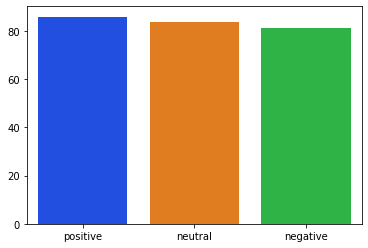

In [53]:
axes2 = sns.barplot(x=values, y=doc_len_avg_freq, palette='bright')

#### Bar Blot for text length

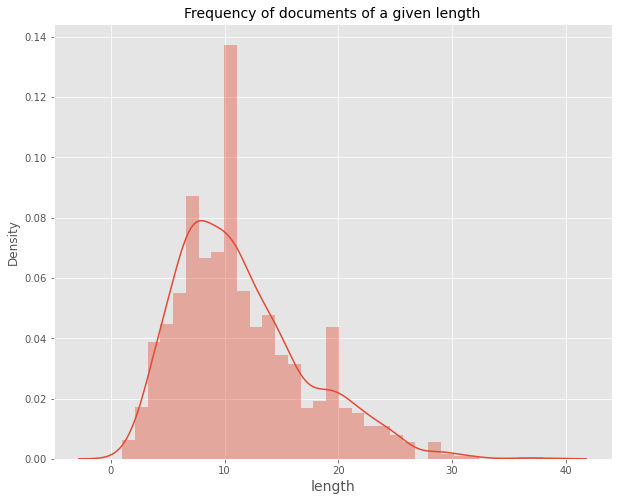

In [29]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
df_clean['length'] = df_clean['doc_clean'].apply(lambda x: len(x.split()))
sns.distplot(df_clean[df_clean['length'] < 5000]['length'])
plt.title('Frequency of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

#### Word Cloud

In [30]:
words = " ".join(cat.split()[1] for cat in (df_clean[df_clean['class']=='positive']).doc_clean)
cloud_positive = WordCloud(collocations = False, background_color = 'white').generate(words)

In [31]:
words = " ".join(cat.split()[1] for cat in (df_clean[df_clean['class']=='negative']).doc_clean)
cloud_negative = WordCloud(collocations = False, background_color = 'white').generate(words)

In [ ]:
plt.imshow(cloud_positive, interpolation='bilinear')
plt.imshow(cloud_negative, interpolation='bilinear')
plt.imshow(cloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.show()

### TF-IDF

In [19]:
vectorizer=TfidfVectorizer(stop_words='english',ngram_range=(1,3),token_pattern=r'\b\w+\b')
tfidf = vectorizer.fit_transform(data)
terms=vectorizer.get_feature_names()
tfidf = tfidf.toarray()

In [20]:
tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
cv_dataframe=pd.DataFrame(tfidf,columns=vectorizer.get_feature_names())
print(cv_dataframe)

        0  0 008  0 008 share  0 01  0 03  0 03 0  0 03 versus  0 04  0 05  \
0     0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
1     0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
2     0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
3     0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
4     0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
...   ...    ...          ...   ...   ...     ...          ...   ...   ...   
1806  0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
1807  0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
1808  0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
1809  0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   
1810  0.0    0.0          0.0   0.0   0.0     0.0          0.0   0.0   0.0   

      0 05 share  ...  ñrnits chairman supervisory  ñrvi  ñrvi 

### Doc freq vs class

In [54]:
pos_wrd_dict = {}
neg_wrd_dict = {}
neut_wrd_dict = {}
for i, j in zip(df_clean['doc_clean'], df_clean['class']):
    if j == 'positive':
        for k in i.split():
            if k not in pos_wrd_dict.keys():
                pos_wrd_dict.update({k:1})
            else:
                pos_wrd_dict[k] +=1
    elif j == 'negative':
        for k in i.split():
            if k not in neg_wrd_dict.keys():
                neg_wrd_dict.update({k:1})
            else:
                neg_wrd_dict[k] +=1
    elif j == 'neutral':
        for k in i.split():
            if k not in neut_wrd_dict.keys():
                neut_wrd_dict.update({k:1})
            else:
                neut_wrd_dict[k] +=1
                

In [55]:
pos_wrd_dict_rev = [[i, j] for j, i in pos_wrd_dict.items()]
neg_wrd_dict_rev = [[i, j] for j, i in neg_wrd_dict.items()]
neut_wrd_dict_rev = [[i, j] for j, i in neut_wrd_dict.items()]

In [56]:
a = []
b = []
c = []
for i in pos_wrd_dict.values():
    a.append(i)
for i in neg_wrd_dict.values():
    b.append(i)
for i in neut_wrd_dict.values():
    c.append(i)

In [57]:
a.sort(reverse=True)
b.sort(reverse=True)
c.sort(reverse=True)

In [58]:
pos_t50 = []
neg_t50 = []
neut_t50 = []

for i in [a, b, c]:
    if i == a:
        for j in a[0:50]:
            for k in pos_wrd_dict_rev:
                if k[0] == j:
                    pos_t50.append(k[1])
                    pos_wrd_dict_rev.remove(k)
    elif i == b:
        for j in b[0:50]:
            for k in neg_wrd_dict_rev:
                if k[0] == j:
                    neg_t50.append(k[1])
                    neg_wrd_dict_rev.remove(k)
    elif i == c:
        for j in c[0:50]:
            for k in neut_wrd_dict_rev:
                if k[0] == j:
                    neut_t50.append(k[1])
                    neut_wrd_dict_rev.remove(k)

In [61]:
values3 = [x for x in pos_t50[0:10]]
freq3 = a[0:10]

values4 = [x for x in neg_t50[0:10]]
freq4 = b[0:10]

values5 = [x for x in neut_t50[0:10]]
freq5 = c[0:10]

In [ ]:
axes3 = sns.barplot(x=values3, y=freq3, palette='bright')
axes3.set(xlabel='Top 10 positive words', ylabel='Frequency')

[Text(0.5, 0, 'Top 10 negative words'), Text(0, 0.5, 'Frequency')]

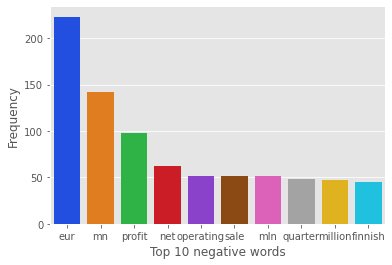

In [42]:
axes4 = sns.barplot(x=values4, y=freq4, palette='bright')
axes4.set(xlabel='Top 10 negative words', ylabel='Frequency')

[Text(0.5, 0, 'Top 10 neutral words'), Text(0, 0.5, 'Frequency')]

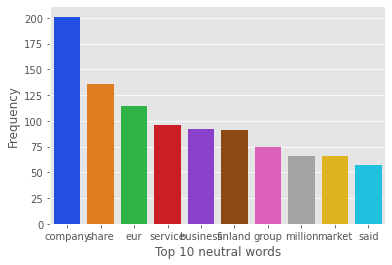

In [43]:
axes5 = sns.barplot(x=values5, y=freq5, palette='bright')
axes5.set(xlabel='Top 10 neutral words', ylabel='Frequency')